### Data from https://www.kaggle.com/c/digit-recognizer

Go to [Data Preparation](#data)

Go to [CNN](#CNN)

Go to [Evaluation](#evaluation)

# Digit Recognizer using TensorFlow Keras

In [2]:
import warnings
warnings.filterwarnings("ignore")

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10928321009699129000
]


### No GPU on this laptop :(

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


<a id='data' />

# Data preparation

In [4]:
from scipy.io import loadmat

In [361]:
mat = loadmat('train_32x32.mat')

In [362]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[[[ 33,  84,  19, ...,  92, 190, 216],
          [ 30,  76,  54, ...,  78, 188, 217],
          [ 38,  59, 110, ..., 101, 191, 212]],
 
         [[ 15,  86,  20, ...,  94, 205, 221],
          [ 23,  73,  52, ...,  82, 203, 222],
          [ 19,  66, 111, ..., 105, 206, 217]],
 
         [[ 15,  77,  25, ..., 114, 220, 226],
          [ 17,  78,  57, ..., 101, 218, 227],
          [ 19,  56, 116, ..., 125, 220, 221]],
 
         ...,
 
         [[ 72,  90,  65, ..., 200, 229, 200],
          [ 65,  78, 144, ..., 201, 231, 199],
          [ 56,  69, 223, ..., 203, 224, 191]],
 
         [[ 82,  88,  78, ..., 192, 229, 193],
          [ 77,  77, 148, ..., 193, 229, 188],
          [ 57,  67, 218, ..., 195, 224, 182]],
 
         [[ 89,  88,  98, ..., 190, 229, 197],
          [ 79,  78, 158, ..., 191, 228, 189],
          [ 59,  66, 220, 

In [363]:
mat['X'].shape

(32, 32, 3, 73257)

In [277]:
mat['X'][:,:,:,0].flatten()

array([ 33,  30,  38, ..., 103, 106,  79], dtype=uint8)

In [279]:
n_data = mat['X'].shape[-1]

In [280]:
mat['X'].reshape(-1,n_data).transpose()[0]

array([ 33,  30,  38, ..., 103, 106,  79], dtype=uint8)

In [281]:
mat['y'].shape

(73257, 1)

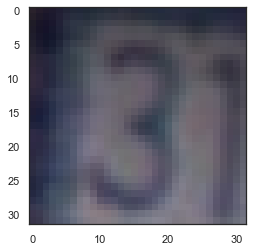

In [372]:
plt.imshow(mat['X'][:,:,:,8])

In [284]:
def display_samples(n_of_samples):
    """ This function shows 6 images with their predicted and real labels"""
    sample_idx_arr = np.random.choice(range(len(mat['y'])),n_of_samples)
    n = 0
    nrows = int(np.sqrt(len(sample_idx_arr)))
    ncols = int(np.ceil(len(sample_idx_arr)/nrows))
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize = (nrows*3,ncols*2))
    plt.subplots_adjust(hspace = 0.6)
    for row in range(nrows):
        for col in range(ncols):
            if (row)*(ncols)+(col+1) > len(sample_idx_arr): return
            sample_i = sample_idx_arr[n]
            ax[row,col].imshow(mat['X'][:,:,:,sample_i])
            ax[row,col].set_title("Index : {}\nLabel : {}".format(sample_i,mat['y'][sample_i]))
            ax[row,col].axis("off")
            n += 1

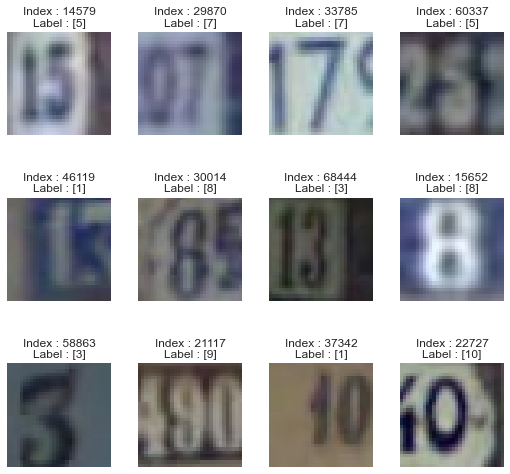

In [285]:
display_samples(12)

In [ ]:
# import cv2
# import numpy as np

# img = cv2.imread("/home/user/Downloads/lena.png")
# blurred_img = cv2.GaussianBlur(img, (21, 21), 0)

# mask = np.zeros((512, 512, 3), dtype=np.uint8)
# mask = cv2.circle(mask, (258, 258), 100, np.array([255, 255, 255]), -1)

# out = np.where(mask==np.array([255, 255, 255]), img, blurred_img)

# cv2.imwrite("./out.png", out)

In [74]:
import cv2

In [ ]:
cv2.GaussianBlur()

In [ ]:
cv2.GaussianBlur(mat,(5,5),0)

In [288]:
img = mat['X'][:,:,:,200]
blurred_img = cv2.GaussianBlur(img, (11, 11), 0)

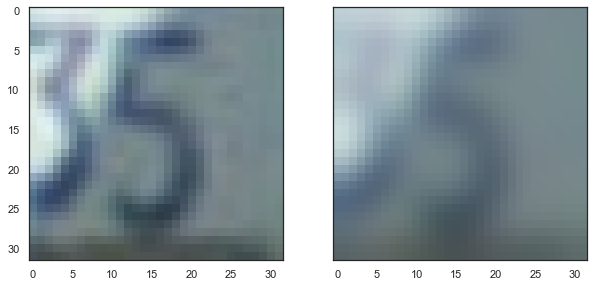

In [289]:
fig, ax = plt.subplots(1,2,sharex=True,sharey=True, figsize = (10,10))
ax[0].imshow(img)
ax[1].imshow(blurred_img)

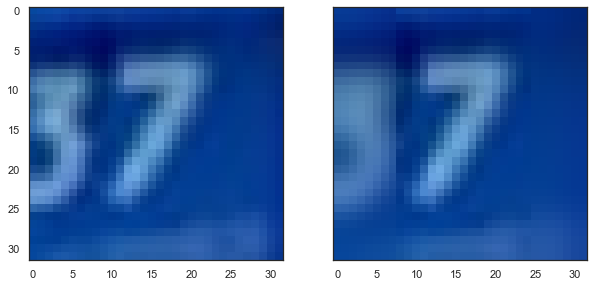

In [320]:
img = mat['X'][:,:,:,200]
blurred_img = cv2.GaussianBlur(img, (9, 9), 0)

width = 32
height = 32
mask = np.zeros((width, height, 3), dtype=np.uint8)
mask = cv2.rectangle(mask, (int(width/4), 0), (int(width*3/4), height), (255, 255, 255), -1)

out = np.where(mask==(255, 255, 255), img, blurred_img)
fig, ax = plt.subplots(1,2,sharex=True,sharey=True, figsize = (10,10))
ax[0].imshow(img)
ax[1].imshow(out)


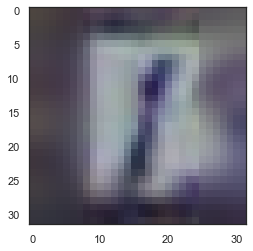

In [182]:
plt.imshow(out)

In [321]:
def mask_side(img):
    width = 32
    height = 32
    kernel_size = max(1,int(np.random.normal(loc=9, scale=2, size=None)))
    kernel_size = kernel_size+ (kernel_size+1)%2 #kernel size must be odd
    blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    mask = np.zeros((width, height, 3), dtype=np.uint8)
    mask = cv2.rectangle(mask, (int(width/4), 0), (int(width*3/4), height), (255, 255, 255), -1)
    out = np.where(mask==(255, 255, 255), img, blurred_img)
    return out

In [322]:
def display_preprocessed_samples(n_of_samples):
    """ This function shows 6 images with their predicted and real labels"""
    sample_idx_arr = np.random.choice(range(len(mat['y'])),n_of_samples)
    n = 0
    nrows = int(np.sqrt(len(sample_idx_arr)))
    ncols = int(np.ceil(len(sample_idx_arr)/nrows))
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize = (nrows*3,ncols*2))
    plt.subplots_adjust(hspace = 0.6)
    for row in range(nrows):
        for col in range(ncols):
            if (row)*(ncols)+(col+1) > len(sample_idx_arr): return
            sample_i = sample_idx_arr[n]
            preprocessed_img = mask_side(mat['X'][:,:,:,sample_i])
            ax[row,col].imshow(preprocessed_img)
            ax[row,col].set_title("Index : {}\nLabel : {}".format(sample_i,mat['y'][sample_i]))
            ax[row,col].axis("off")
            n += 1

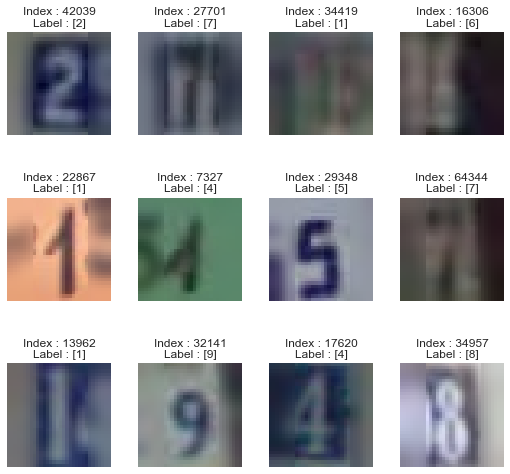

In [294]:
display_preprocessed_samples(12)

In [295]:
preprocessed_set = np.zeros((mat['X'].shape[3],mat['X'].shape[0],mat['X'].shape[1]),dtype=np.uint8)

In [296]:
preprocessed_set.transpose(2,0,1).shape

(32, 73257, 32)

In [193]:
from tqdm import tqdm

Gray Scale: 0.2989 R + 0.5870 G + 0.1140 B 

In [297]:
preprocessed_set = np.zeros((mat['X'].shape[3],mat['X'].shape[0],mat['X'].shape[1]),dtype=np.uint8)
for i in tqdm(range(len(mat['y']))):
    preprocessed_img = mask_side(mat['X'][:,:,:,i])
    preprocessed_set[i,...] = np.dot(preprocessed_img,[0.2989, 0.5870, 0.1140])

100%|██████████| 73257/73257 [00:16<00:00, 4473.57it/s]


In [298]:
# df = pd.DataFrame(np.hstack((preprocessed_set.reshape(-1,26032).transpose(), mat['y'])))
df = pd.DataFrame(np.hstack((preprocessed_set.reshape(n_data,-1), mat['y'])))

In [299]:
df #3073 = 32x32x3 + 1,  1025 = 32x32 +1

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,26,28,32,39,49,57,63,69,74,77,...,103,103,96,98,100,101,101,102,102,1
1,67,65,61,56,50,47,46,48,45,70,...,103,103,101,101,101,100,101,101,101,9
2,50,50,51,52,55,59,65,73,65,78,...,135,134,133,132,131,130,130,130,130,2
3,81,83,88,94,103,111,118,124,124,126,...,126,122,139,130,126,124,124,124,123,3
4,129,130,132,135,137,139,138,137,135,133,...,143,144,141,141,141,140,141,141,141,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73252,35,35,34,34,33,33,32,32,32,33,...,29,28,51,52,55,59,63,65,66,2
73253,33,32,32,32,32,32,32,33,32,31,...,29,29,30,29,30,30,30,30,30,2
73254,106,110,123,140,159,175,187,197,207,217,...,215,214,211,210,209,209,208,208,208,1
73255,202,204,209,214,217,219,220,220,218,221,...,224,227,223,222,220,216,211,208,207,6


In [300]:
df.rename(columns={1024:'label'}, inplace = True)

In [259]:
# Load the data
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

1     13861
2     10585
3      8497
4      7458
5      6882
6      5727
7      5595
8      5045
10     4948
9      4659
Name: label, dtype: int64

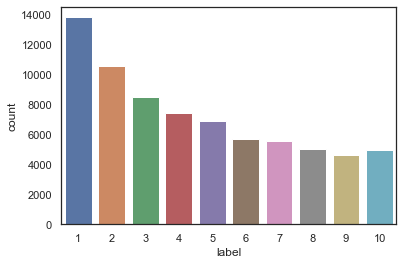

In [301]:
trainY = df["label"]
trainX = df.drop(labels = ["label"],axis = 1) 
del df 

g = sns.countplot(trainY)

trainY.value_counts()

We have similar counts for the 10 digits.

In [302]:
trainX

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,26,28,32,39,49,57,63,69,74,77,...,102,103,103,96,98,100,101,101,102,102
1,67,65,61,56,50,47,46,48,45,70,...,103,103,103,101,101,101,100,101,101,101
2,50,50,51,52,55,59,65,73,65,78,...,135,135,134,133,132,131,130,130,130,130
3,81,83,88,94,103,111,118,124,124,126,...,136,126,122,139,130,126,124,124,124,123
4,129,130,132,135,137,139,138,137,135,133,...,142,143,144,141,141,141,140,141,141,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73252,35,35,34,34,33,33,32,32,32,33,...,31,29,28,51,52,55,59,63,65,66
73253,33,32,32,32,32,32,32,33,32,31,...,24,29,29,30,29,30,30,30,30,30
73254,106,110,123,140,159,175,187,197,207,217,...,217,215,214,211,210,209,209,208,208,208
73255,202,204,209,214,217,219,220,220,218,221,...,222,224,227,223,222,220,216,211,208,207


- 32X32 pixels

## Train set

In [ ]:
mat = loadmat('train_32x32.mat')
preprocessed_set = np.zeros((mat['X'].shape[3],mat['X'].shape[0],mat['X'].shape[1]),dtype=np.uint8)
for i in tqdm(range(len(mat['y']))):
    preprocessed_img = mask_side(mat['X'][:,:,:,i])
    preprocessed_set[i,...] = np.dot(preprocessed_img,[0.2989, 0.5870, 0.1140])
df = pd.DataFrame(np.hstack((preprocessed_set.reshape(len(mat['y']),-1), mat['y'])))
df.rename(columns={1024:'label'}, inplace = True)
trainY = df["label"]
trainX = df.drop(labels = ["label"],axis = 1) 
del df 

g = sns.countplot(trainY)

trainY.value_counts()

## Test set

100%|██████████| 26032/26032 [00:05<00:00, 4522.72it/s]


1     5099
2     4149
3     2882
4     2523
5     2384
7     2019
6     1977
10    1744
8     1660
9     1595
Name: label, dtype: int64

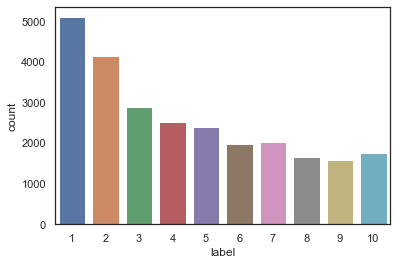

In [305]:
mat = loadmat('test_32x32.mat')
preprocessed_set = np.zeros((mat['X'].shape[3],mat['X'].shape[0],mat['X'].shape[1]),dtype=np.uint8)
for i in tqdm(range(len(mat['y']))):
    preprocessed_img = mask_side(mat['X'][:,:,:,i])
    preprocessed_set[i,...] = np.dot(preprocessed_img,[0.2989, 0.5870, 0.1140])
df = pd.DataFrame(np.hstack((preprocessed_set.reshape(len(mat['y']),-1), mat['y'])))
df.rename(columns={1024:'label'}, inplace = True)
testY = df["label"]
testX = df.drop(labels = ["label"],axis = 1) 
del df 

g = sns.countplot(testY)

testY.value_counts()

## Missing values

In [306]:
# Check the data
trainX.isnull().sum().sum()

0

In [308]:
testX.isnull().sum().sum()

0

No missing values in the train and test dataset.

In [309]:
trainX.shape

(73257, 1024)

In [319]:
trainY[300]

3

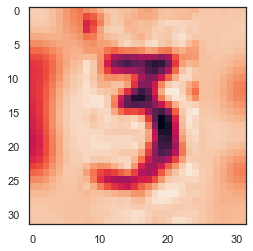

In [323]:
# Some examples
g = plt.imshow(trainX.values.reshape(-1,32,32)[500])

## Grayscale Normalization

In [324]:
# Normalize the data
trainX = trainX / trainX.max().max() #258
testX = testX / trainX.max().max()

## Reshape

In [334]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
trainX = trainX.values.reshape(-1,32,32,1)
testX = testX.values.reshape(-1,32,32,1)

- grayscaled images, hence one channel

## Label encoding

In [348]:
trainY = np.where(trainY==10,0,trainY)
testY = np.where(testY==10,0,testY)

In [349]:
# labels to one hot vectors
trainY = to_categorical(trainY, num_classes = 10)
testY = to_categorical(testY, num_classes = 10)

In [350]:
trainY

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [351]:
trainY.shape

(73257, 10)

## Split training and valdiation set 

In [352]:
# Split the train and the validation set for the fitting
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.1)

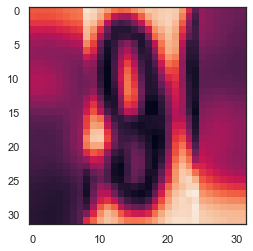

In [353]:
# Some examples
g = plt.imshow(trainX[0][:,:,0])

<a id='CNN' />

# CNN
## Modeling

In [354]:
#[[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1))) #filters = num of filters, kernel_size = filter size
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


- ## RMSprop Optimizer - not used here

In [56]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

### Compile

In [63]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Annealer

In [58]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

- ## Adam Optimizer - no need annealer

In [355]:
optimizer = Adam(lr=0.001,beta_1=0.9,beta_2=0.999)

### compile

In [356]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## Epochs and Batch Size

In [373]:
epochs = 10
batch_size = 86

## Augmentation

In [374]:
# prevent overfitting
datagen = ImageDataGenerator(
        rotation_range=10,  # degree
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1) 


datagen.fit(trainX)

- ### Adams

In [375]:
# Fit the model
history = model.fit_generator(datagen.flow(trainX,trainY,batch_size=batch_size),
                             epochs=epochs,validation_data=(valX,valY),
                              verbose = 2, steps_per_epoch=trainX.shape[0]//batch_size)

Epoch 1/10
 - 330s - loss: 1.7458 - accuracy: 0.3909 - val_loss: 0.5849 - val_accuracy: 0.8311
Epoch 2/10
 - 326s - loss: 0.8061 - accuracy: 0.7472 - val_loss: 0.3891 - val_accuracy: 0.8845
Epoch 3/10
 - 322s - loss: 0.6389 - accuracy: 0.8018 - val_loss: 0.3336 - val_accuracy: 0.9013
Epoch 4/10
 - 324s - loss: 0.5763 - accuracy: 0.8235 - val_loss: 0.3053 - val_accuracy: 0.9141
Epoch 5/10
 - 316s - loss: 0.5261 - accuracy: 0.8391 - val_loss: 0.2857 - val_accuracy: 0.9173
Epoch 6/10
 - 323s - loss: 0.5001 - accuracy: 0.8501 - val_loss: 0.2788 - val_accuracy: 0.9219
Epoch 7/10
 - 322s - loss: 0.4838 - accuracy: 0.8545 - val_loss: 0.2696 - val_accuracy: 0.9237
Epoch 8/10
 - 326s - loss: 0.4649 - accuracy: 0.8592 - val_loss: 0.2588 - val_accuracy: 0.9283
Epoch 9/10
 - 320s - loss: 0.4409 - accuracy: 0.8678 - val_loss: 0.2461 - val_accuracy: 0.9319
Epoch 10/10
 - 321s - loss: 0.4376 - accuracy: 0.8688 - val_loss: 0.2497 - val_accuracy: 0.9313


<a id='evaluation' />

In [383]:
history.history

{'val_loss': [0.5849162866403391,
  0.38911484030143767,
  0.33357477819874026,
  0.30532405150577796,
  0.28566264919072204,
  0.27884664622456073,
  0.26956855136531965,
  0.25878849618875227,
  0.2461094156725303,
  0.24967960451319995],
 'val_accuracy': [0.8311493396759033,
  0.8845208883285522,
  0.901310384273529,
  0.9141414165496826,
  0.917280912399292,
  0.9219219088554382,
  0.9236963987350464,
  0.9283374547958374,
  0.9318864345550537,
  0.9313404560089111],
 'loss': [1.7461199176511548,
  0.8059404128142212,
  0.6388309766123946,
  0.5762424988576098,
  0.5259877941889773,
  0.5000162596537462,
  0.48375310803276234,
  0.4649249715050638,
  0.4407491751566809,
  0.43774449802769355],
 'accuracy': [0.3908725,
  0.7471638,
  0.8017921,
  0.82349455,
  0.839107,
  0.85005695,
  0.8544764,
  0.85916924,
  0.8678411,
  0.8688131]}

## Save and Load

In [376]:
import pickle

In [377]:
with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [380]:
history_load = pickle.load(open('trainHistoryDict', "rb"))

In [388]:
model.save('keras_model_save')

In [390]:
import keras
model_load = keras.models.load_model('keras_model_save')

# Evaluation
## Training and validation curves

- ### Adams

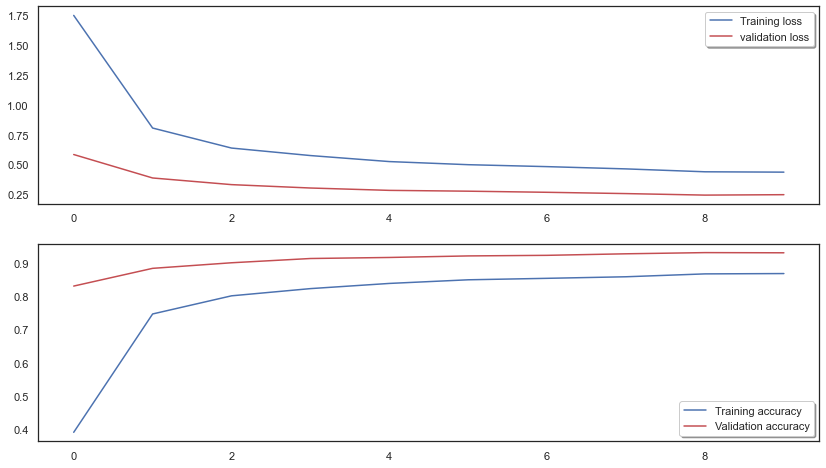

In [392]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1,figsize = (14,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix

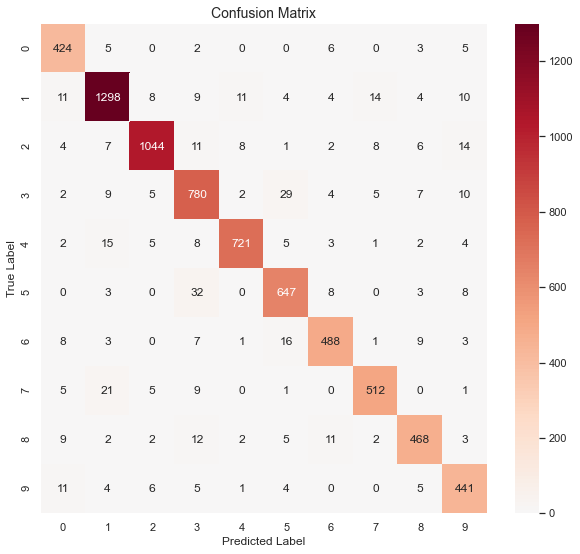

In [393]:
# confusion matrix
# Predict the values from the validation dataset
Y_pred = model.predict(valX)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(valY,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plt.figure(figsize=(10,9))
sns.heatmap(confusion_mtx, cmap='RdBu_r', annot=True, fmt= 'd', center=0.0)
plt.title("Confusion Matrix",fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [402]:
(Y_true==Y_pred_classes).sum()/len(Y_pred_classes)

0.9062307928703135

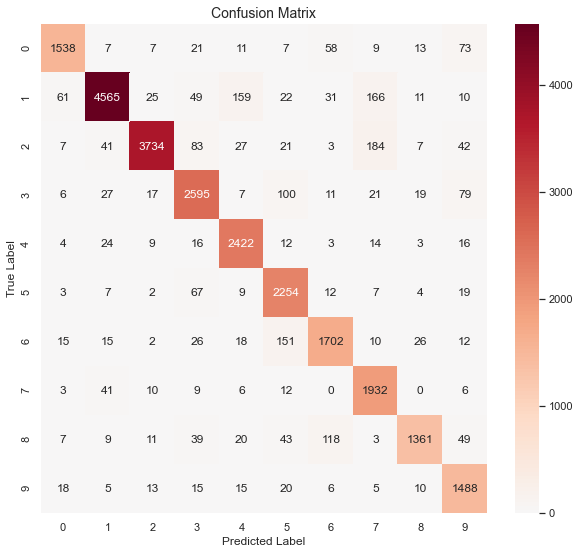

In [394]:
# confusion matrix test set
# Predict the values from the validation dataset
Y_pred = model.predict(testX)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(testY,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plt.figure(figsize=(10,9))
sns.heatmap(confusion_mtx, cmap='RdBu_r', annot=True, fmt= 'd', center=0.0)
plt.title("Confusion Matrix",fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Errors

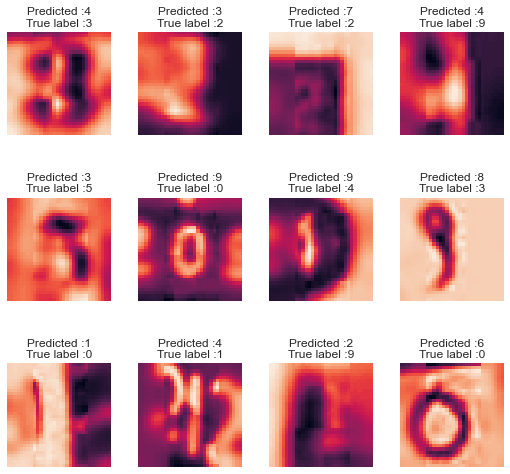

In [405]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
testX_errors = testX[errors]
#valX_errors = valX[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = int(np.sqrt(len(errors_index)))
    ncols = int(np.ceil(len(errors_index)/nrows))
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize = (nrows*3,ncols*2))
    plt.subplots_adjust(hspace = 0.6)
    for row in range(nrows):
        for col in range(ncols):
            if (row)*(ncols)+(col+1) > len(errors_index): return
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32)))
            ax[row,col].set_title("Predicted :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            ax[row,col].axis("off")
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top n errors 
most_important_errors = sorted_dela_errors[-12:]

# Show the top n errors
display_errors(most_important_errors, testX_errors, Y_pred_classes_errors, Y_true_errors)